In [ ]:
#|hide
## Standard libraries
import os
import math
import numpy as np
import time
from fastcore.all import *
from nbdev.showdoc import *

# Configure environment
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false' # Tells Jax not to hog all of the memory to this process.
import nest_asyncio
nest_asyncio.apply()

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm, trange

## project specifics
import diffusion_curvature
import pygsp
import jax
import jax.numpy as jnp
from diffusion_curvature.graphs import *
from diffusion_curvature.datasets import *
from diffusion_curvature.core import *
from diffusion_curvature.utils import *
from diffusion_curvature.comparison_space import *
from diffusion_curvature.sadspheres import *

%load_ext autoreload
%autoreload 2
    
jax.devices()
jax.default_device = jax.devices("cpu")

[autoreload of diffusion_curvature.flattening.mioflow failed: Traceback (most recent call last):
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_gener

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2c4 Normalized Laziness
> Controlling for diffusion speed

**Hypothesis**: Stuff will happen

# Test Case

In [ ]:
X,ks = torus(2000,use_guide_points=True)

In [ ]:
graph_former = partial(get_adaptive_graph, alpha=1, k=5)
G = graph_former(X)
G = pygsp.graphs.Graph(G.W)
DC = DiffusionCurvature(
    laziness_method="Wasserstein",
    flattening_method="Fixed",
    comparison_method="Subtraction",
    diffusion_type = "heat kernel",
    graph_former=graph_former,
    points_per_cluster=None,  # construct separate comparison spaces around each point
    comparison_space_size_factor=1,
    smoothing=0,
)

2024-03-07 17:23:19,423:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


In [ ]:
ks_dc, ks_0, P, Pt, t = DC.unsigned_curvature(G, t=200, _also_return_first_scale=True)

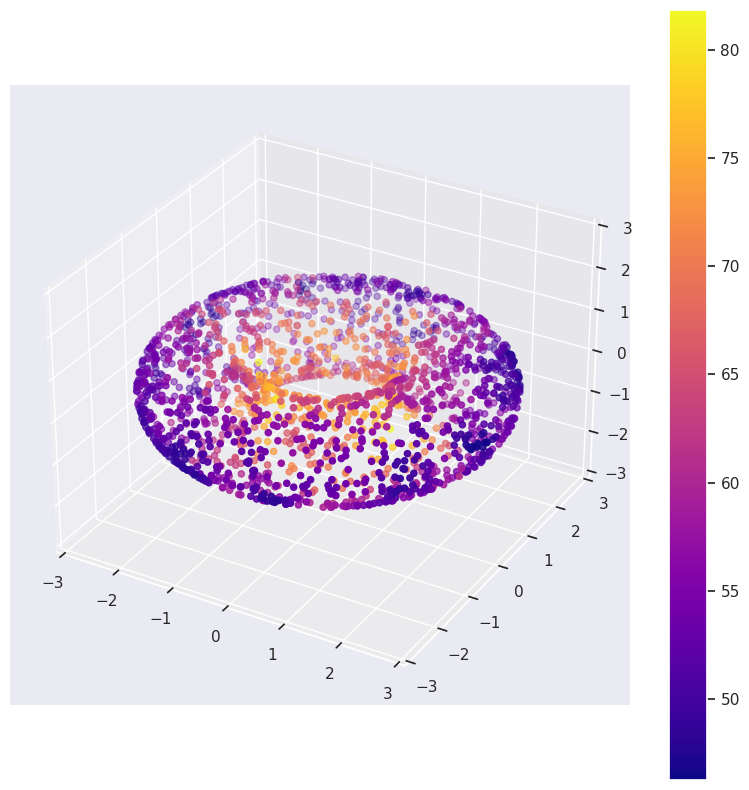

In [ ]:
plot_3d(X,ks_dc,colorbar=True)

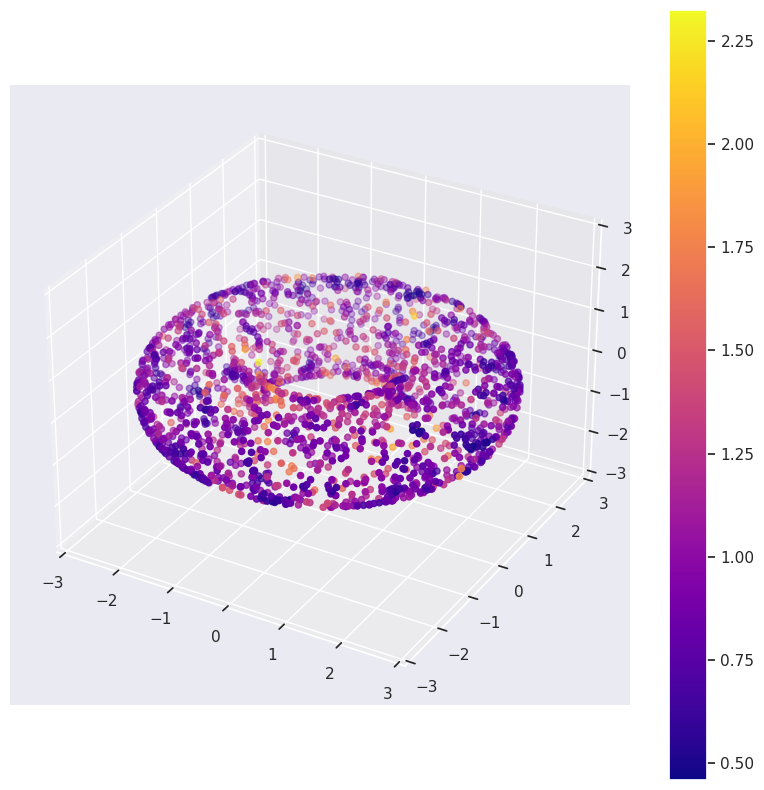

In [ ]:
plot_3d(X,ks_0, colorbar=True)

In [ ]:
from diffusion_curvature.heat_diffusion import jax_power_matrix

In [ ]:
dz = jax_power_matrix(DC.P, 10) @ ks_0

In [ ]:
dz

Array([1.0449486 , 1.2450544 , 0.9720626 , ..., 0.9172435 , 0.71132255,
       0.90463585], dtype=float32)

In [ ]:
jnp.sum(jax_power_matrix(DC.P, 10),axis=-1)

Array([0.9999877, 0.9992317, 0.9990181, ..., 1.0005169, 1.0004473,
       1.0028   ], dtype=float32)

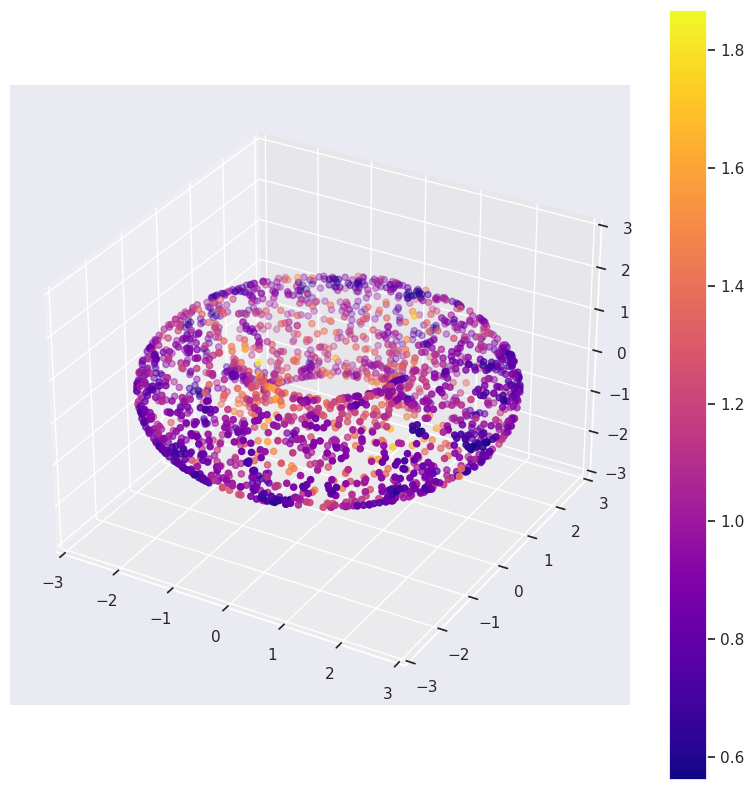

In [ ]:
plot_3d(X,dz, colorbar=True)

In [ ]:
DC.P[0]

Array([9.4516259e-01, 2.5215305e-25, 8.6485088e-30, ..., 2.1166708e-23,
       2.5129790e-23, 3.8437673e-08], dtype=float32)

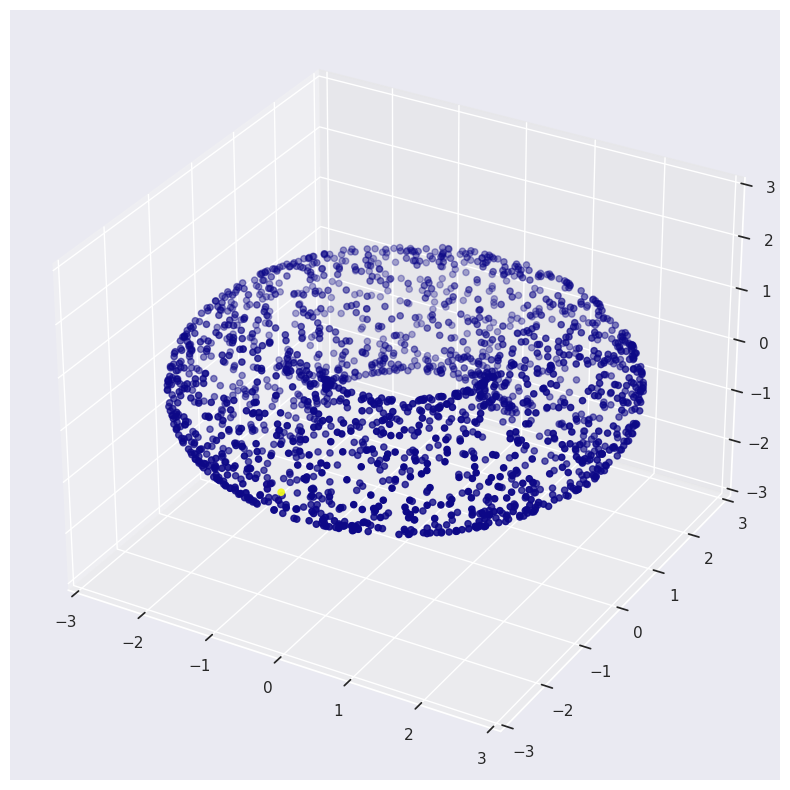

In [ ]:
plot_3d(X, DC.P[0])

In [ ]:
ks_dc

Array([5.1343727, 5.6625824, 5.718016 , ..., 5.111926 , 4.4068885,
       4.9794197], dtype=float32)

In [ ]:
ks_0

Array([10.147547, 21.268236,  8.729103, ..., 11.231356, 17.421688,
       10.304707], dtype=float32)

In [ ]:
divided = ks_dc - ks_0

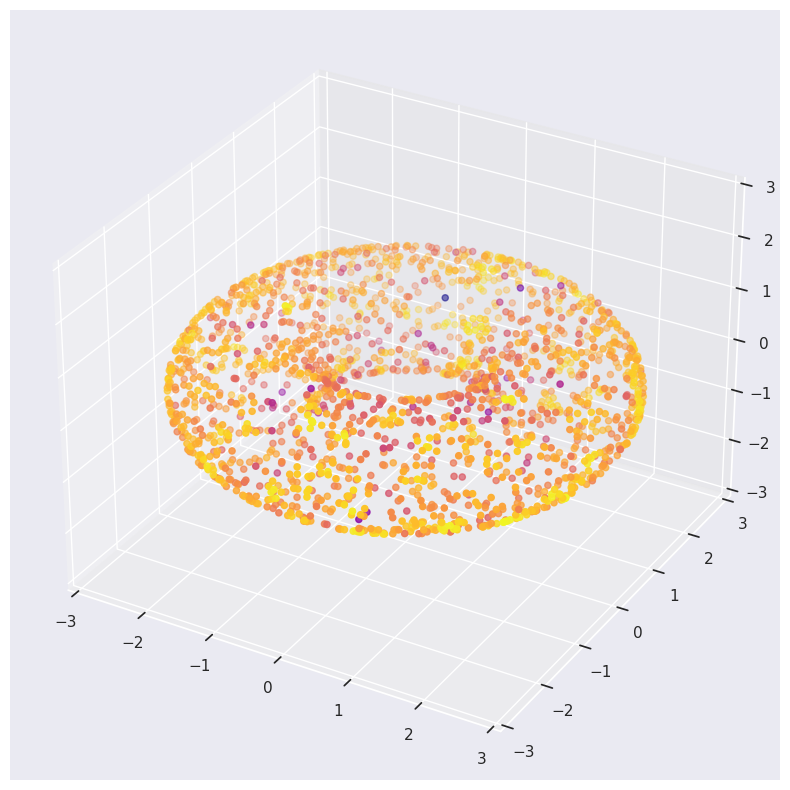

In [ ]:
plot_3d(X, divided)

# Higher Dimensional Data

In [ ]:
from diffusion_curvature.sadspheres import *
import asyncio

import logging
logging.getLogger().setLevel(logging.ERROR)


def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

In [ ]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 20, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k, t):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    G = pygsp.graphs.Graph(G.W)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        diffusion_type="heat kernel",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.unsigned_curvature(G, t=t)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=} {t=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [5]:
            for t in [1,100]:
                tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k, t)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

[autoreload of diffusion_curvature.flattening.mioflow failed: Traceback (most recent call last):
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/piriac/mambaforge/envs/zetteldev-diffcurv/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_gener

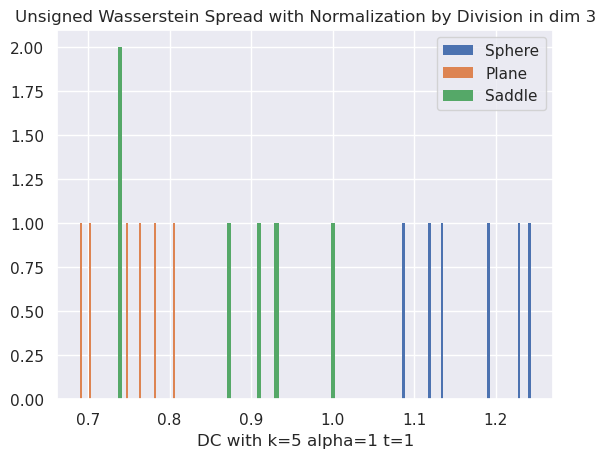

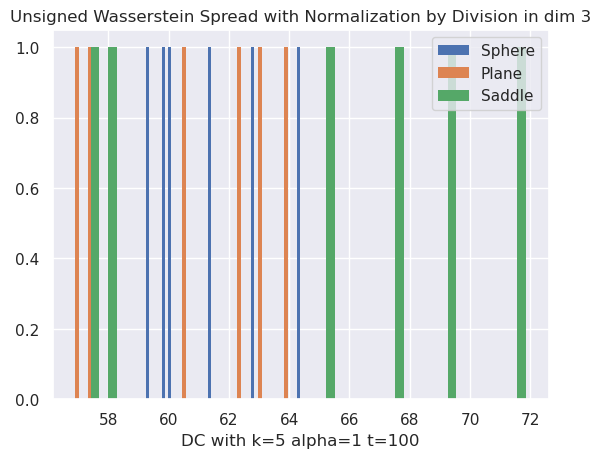

TypeError: descriptor '__weakref__' for 'SadSpheres' objects doesn't apply to a 'SadSpheres' object

In [ ]:
SS.plot(title="Unsigned Wasserstein Spread with Normalization by Division in dim 3")
SS.table()

In [ ]:
import asyncio
from tqdm import trange
dim = 3
SS = SadSpheres(
    dimension = dim, # Dimension of saddles and spheres
    num_pointclouds = 20, # num pointclouds to make in total
    num_points = 2000, # num points per pointclouds
    noise_level = 0, # from 0 to 1. 1 is all noise.
    include_planes = True,
)

async def process_alpha_k(X, alpha, k, t):
    global SS
    graph_former = partial(get_adaptive_graph, alpha=alpha, k=k)
    G = graph_former(X)
    DC = DiffusionCurvature(
        laziness_method="Wasserstein",
        flattening_method="Fixed",
        comparison_method="Subtraction",
        graph_former=graph_former,
        points_per_cluster=None,  # construct separate comparison spaces around each point
        comparison_space_size_factor=1,
    )
    ks = DC.unsigned_curvature(G, t=t)
    SS.update(ks[0], method_name=f"DC with {k=} {alpha=} {t=}")

async def process_X(X, pbar):
    global SS
    tasks = []
    for alpha in [1]:
        for k in [5]:
            for t in [1,25]:
                tasks.append(asyncio.create_task(process_alpha_k(X, alpha, k, t)))
    await asyncio.gather(*tasks)
    pbar.update(1)

async def main():
    global SS
    pbar = trange(len(SS), desc="Processing X's")
    for i, X in enumerate(SS):
        await process_X(X, pbar)
    pbar.close()

# Run the main function using asyncio.run()
asyncio.run(main())

Processing X's: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.67it/s]


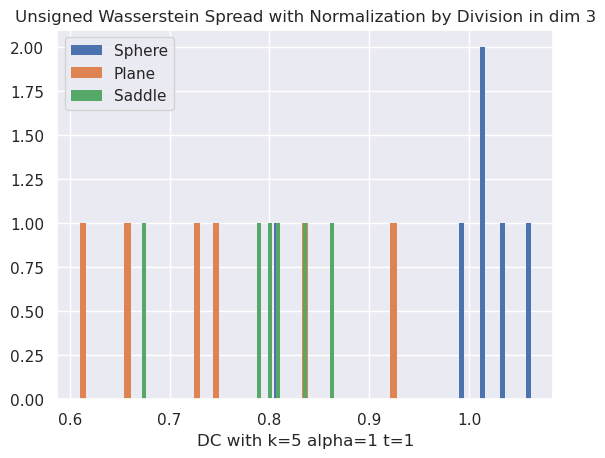

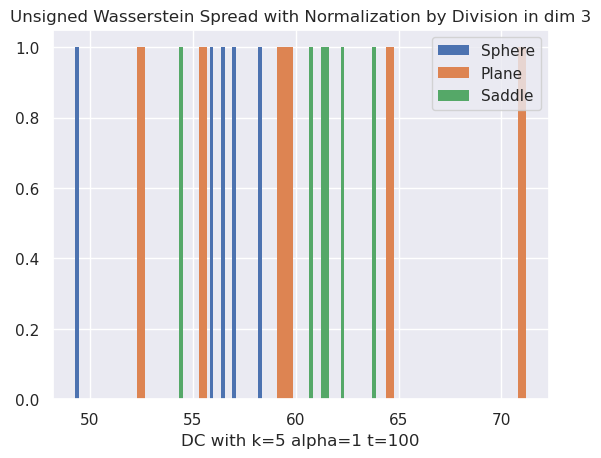

,pearson_r,sign_score
ks,"(1.0, 0.0)",1.098612
DC with k=5 alpha=1 t=1,"(0.39165551577749597, 0.10797919764552015)",0.000000
DC with k=5 alpha=1 t=100,"(-0.33936876037069685, 0.1682795867329328)",0.000000


In [ ]:
SS.plot(title="Unsigned Wasserstein Spread with Normalization by Division in dim 3")
SS.table()

# Conclusion